## MNIST Project based on XCS229 Problem set 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse

In [2]:
# hyperparameters
HPARAMS = {
    'batch_size': 1000,
    'num_epochs': 30,
    'learning_rate': 0.4,
    'num_hidden': 300,
    'reg': 0.001
}

In [3]:
def softmax(x):
    """
    Compute softmax function for a batch of input values.
    First dim of the input: batch size.
    Second dim of the input: prob of every class in the output.
    Only sum over the second dim.
    
    Important: Avoid overflow for this function. It overflows for very big numbers like e^10000.

    Args:
        x : 2d numpy float array (batch_size , number_of_classes)
        
    Returns: 
        2d numpy float array containing softmax results (batch_size, number_of_classes)
    """
    
    # Prof. Mark Cramer suggested to apply a stability trick to avoid overflow
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exps = np.exp(x_shifted)
    softmax_values = exps / np.sum(exps, axis=1, keepdims=True)
    
    return softmax_values

In [4]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input.

    Args:
        x (numpy float array): 
        
    Returns: 
        A numpy float array containing sigmoid results
    """
    
    # We'll use one expression for positive numbers, and another one for negative numbers
    
    pos_mask = (x >= 0)
    neg_mask = ~pos_mask
    z = np.zeros_like(x)
    
    # when x is positive: 1 / (1 + exp(-x))
    z[pos_mask] = 1 / (1 + np.exp(-x[pos_mask]))
    
    # when x is negative: exp(x) / (1 + exp(x)) more stable
    z[neg_mask] = np.exp(x[neg_mask]) / (1 + np.exp(x[neg_mask]))
    
    return z

In [5]:
def get_initial_params(input_size, num_hidden, num_output):
    """
    Compute initial parameters of the NN.
    
    This function returns dict mapping parameters names to numpy arrays containing
    initial values for those parameters.
    
    4 parameters for this model:
    W1 is the weight matrix for the hidden layer of size input_size x num_hidden
    b1 is the bias vector for the hidden layer of size num_hidden
    W2 is the weight matrix for the output layers of size num_hidden x num_output
    b2 is the bias vector for the output layer of size num_output
    
    weight matrices should be initialized with a random normal distribution centered on zero and with scale 1.
    bias vectors should be initialized with zero.

    Args:
        input_size : size of input data
        num_hidden (int): number of hidden states
        num_output (int): number of output classes
        
    Returns: 
        A dict mapping parameter names to numpy arrays
    """
    
    params = {
        'W1': np.random.randn(input_size, num_hidden),
        'b1': np.zeros(num_hidden),
        'W2': np.random.randn(num_hidden, num_output),
        'b2': np.zeros(num_output)
    }
    
    return params

In [6]:
def forward_prop(data, labels, params):
    """
    Implement the forward layer

    Args:
        data (numpy array): It's the input
        labels (numpy array): Contains labels
        params : dictionary mapping parameter names to arrays. 
        W1 and b1 are weights and bias for the hidden layer
        W2 and b2 are the weights and bias for the output layer
        
    Returns: 
        3 element tuple containing:
            1. numpy array of the activations (after sigmoid) of the hidden layer
            2. numpy array of the output (after softmax) of the output layer
            3. the average loss of these data elements 
    """
    # hidden layer
    z1 = data @ params['W1'] + params['b1']
    a1 = sigmoid(z1)
    
    # output layer
    z2 = a1 @ params['W2'] + params['b2']
    output = softmax(z2)
    
    # Calculate average cross-entropy loss
    cross = labels * np.log(output)
    
    loss = -np.sum(cross) / data.shape[0]
    return a1, output, loss

In [7]:
def backward_prop(data, labels, params, forward_prop_func):
    """
    Implement the backward propagation gradient computation step for a NN

    Args:
        data (numpy array): input
        labels (numpy array): contains labels
        params (dict): maps parameters names to numpy arrays
        forward_prop_func: function described above
    
    Returns: 
        dictionary of strings to numpy arrays where each key represents the name
        of a weight and the values represent the gradient of the loss with respect to that weight.
        
        In particular, it shoudl have 4 elements:
        W1, W2, b1, and b2.
    """
    a1, output, _ = forward_prop_func(data, labels, params)
    error_out = output - labels
    grad_W2 = a1.T @ error_out / data.shape[0]
    grad_b2 = np.sum(error_out, axis=0) / data.shape[0]
    
    error_hidden = error_out @ params["W2"].T * a1 * (1 - a1)
    grad_W1 = data.T @ error_hidden / data.shape[0]
    grad_b1 = np.sum(error_hidden, axis=0) / data.shape[0]
    
    grads = {'W1': grad_W1, 'b1': grad_b1, 'W2': grad_W2, 'b2': grad_b2}
    
    return grads

In [8]:
def backward_prop_regularized(data, labels, params, forward_prop_func, reg):
    """
    Implement the backward propagation gradient computation step for a neural network

    Args:
        data: A numpy array containing the input
        labels: A 2d numpy array containing the labels
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2 and b2
            W1 and b1 represent the weights and bias for the hidden layer of the network
            W2 and b2 represent the weights and bias for the output layer of the network
        forward_prop_func: A function that follows the forward_prop API above
        reg: The regularization strength (lambda)

    Returns:
        A dictionary of strings to numpy arrays where each key represents the name of a weight
        and the values represent the gradient of the loss with respect to that weight.

        In particular, it should have 4 elements:
            W1, W2, b1, and b2
    """
    a1, output, _ = forward_prop_func(data, labels, params)
    error_out = output - labels

    # Gradients for W2 and b2 (output layer)
    grad_W2 = (a1.T @ error_out + reg * params['W2']) / data.shape[0]
    grad_b2 = np.sum(error_out, axis=0) / data.shape[0]

    # Gradients for W1 and b1 (hidden layer)
    error_hidden = error_out @ params["W2"].T * a1 * (1 - a1)
    grad_W1 = (data.T @ error_hidden + reg * params['W1']) / data.shape[0]
    grad_b1 = np.sum(error_hidden, axis=0) / data.shape[0]

    grads = {'W1': grad_W1, 'b1': grad_b1, 'W2': grad_W2, 'b2': grad_b2}
    return grads

In [13]:
def gradient_descent_epoch(train_data, train_labels, learning_rate, batch_size, params, forward_prop_func, backward_prop_func):
    """
    Perform one epoch of gradient descent on the given training data using the provided learning rate.

    This code should update the parameters stored in params.
    It should not return anything

    Args:
        train_data: A numpy array containing the training data
        train_labels: A numpy array containing the training labels
        learning_rate: The learning rate
        batch_size: The amount of items to process in each batch
        params: A dict of parameter names to parameter values that should be updated.
        forward_prop_func: A function that follows the forward_prop API
        backward_prop_func: A function that follows the backwards_prop API

    Returns: This function returns nothing.
    """

    for i in range(0, train_data.shape[0], batch_size):
        batch_data = train_data[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        #print(f'Iteration from {i} to {i+batch_size}.')
        # print(f'data shape: {batch_data.shape}')
        # print(f'labels shape: {batch_labels.shape}')

        grads = backward_prop_func(
            batch_data, batch_labels, params, forward_prop_func)

        params['W1'] -= learning_rate * grads['W1']
        params['b1'] -= learning_rate * grads['b1']
        params['W2'] -= learning_rate * grads['W2']
        params['b2'] -= learning_rate * grads['b2']
        
        return

In [10]:
def nn_train(
        train_data, train_labels, dev_data, dev_labels,
        get_initial_params_func, forward_prop_func, backward_prop_func,
        num_hidden=HPARAMS['num_hidden'], learning_rate=HPARAMS['learning_rate'],
        num_epochs=HPARAMS['num_epochs'], batch_size=HPARAMS['batch_size']):

    print(f'Num hidden:    {num_hidden}')
    print(f'Learning rate: {learning_rate}')
    print(f'Num epochs:    {num_epochs}')
    print(f'Bach size:     {batch_size}')

    (nexp, dim) = train_data.shape

    params = get_initial_params_func(dim, num_hidden, 10)

    cost_train = []
    cost_dev = []
    accuracy_train = []
    accuracy_dev = []
    for epoch in range(num_epochs):
        gradient_descent_epoch(train_data, train_labels,
                               learning_rate, batch_size, params, forward_prop_func, backward_prop_func)

        h, output, cost = forward_prop_func(train_data, train_labels, params)
        cost_train.append(cost)
        accuracy_train.append(compute_accuracy(output, train_labels))
        h, output, cost = forward_prop_func(dev_data, dev_labels, params)
        cost_dev.append(cost)
        accuracy_dev.append(compute_accuracy(output, dev_labels))

    return params, cost_train, cost_dev, accuracy_train, accuracy_dev


def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy


def compute_accuracy(output, labels):
    accuracy = (np.argmax(output, axis=1) ==
                np.argmax(labels, axis=1)).sum() * 1. / labels.shape[0]
    return accuracy


def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size), labels.astype(int)] = 1
    return one_hot_labels


def read_data(images_file, labels_file, max_rows=None):
    if max_rows is None:
        x = np.loadtxt(images_file, delimiter=',')
        y = np.loadtxt(labels_file, delimiter=',')
    else:
        x = np.loadtxt(images_file, delimiter=',', max_rows=max_rows)
        y = np.loadtxt(labels_file, delimiter=',', max_rows=max_rows)
    return x, y


def run_train_test(name, all_data, all_labels, backward_prop_func, num_epochs, plot=True, test_set=False):
    params, cost_train, cost_dev, accuracy_train, accuracy_dev = nn_train(
        all_data['train'], all_labels['train'],
        all_data['dev'], all_labels['dev'],
        get_initial_params, forward_prop, backward_prop_func,
        num_hidden=HPARAMS['num_hidden'], learning_rate=HPARAMS['learning_rate'],
        num_epochs=HPARAMS['num_epochs'], batch_size=HPARAMS['batch_size']
    )

    t = np.arange(num_epochs)

    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1)

        ax1.plot(t, cost_train, 'r', label='train')
        ax1.plot(t, cost_dev, 'b', label='dev')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss')
        if name == 'baseline':
            ax1.set_title('Without Regularization')
        else:
            ax1.set_title('With Regularization')
        ax1.legend()

        ax2.plot(t, accuracy_train, 'r', label='train')
        ax2.plot(t, accuracy_dev, 'b', label='dev')
        ax2.set_xlabel('epochs')
        ax2.set_ylabel('accuracy')
        ax2.legend()

        fig.savefig('./' + name + '.pdf')

    if test_set:
        accuracy = nn_test(all_data['test'], all_labels['test'], params)
        print('For model %s, achieved test set accuracy: %f' % (name, accuracy))

In [22]:
def visualize_sample_images(data, labels, num_samples=10):
    """
    Visualize sample images and their labels from the dataset.
    
    Args:
        data (numpy array): MNIST image data (normalized).
        labels (numpy array): Corresponding labels (one-hot encoded).
        num_samples (int): Number of images to display.
    """
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(6, num_samples // 6, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.suptitle("Sample MNIST Images")
    plt.show()

Num hidden:    300
Learning rate: 0.4
Num epochs:    30
Bach size:     1000
Regularization param:  0.001
Num hidden:    300
Learning rate: 0.4
Num epochs:    30
Bach size:     1000


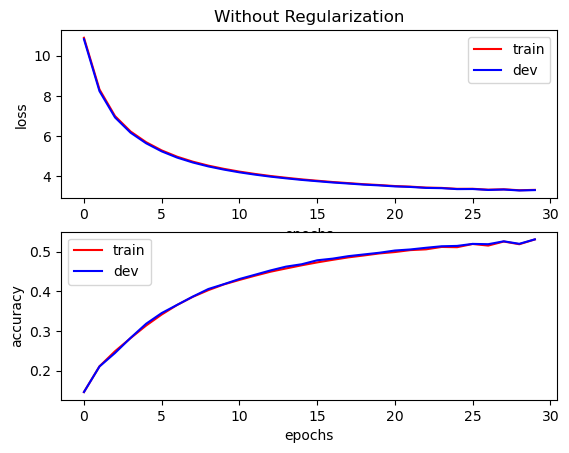

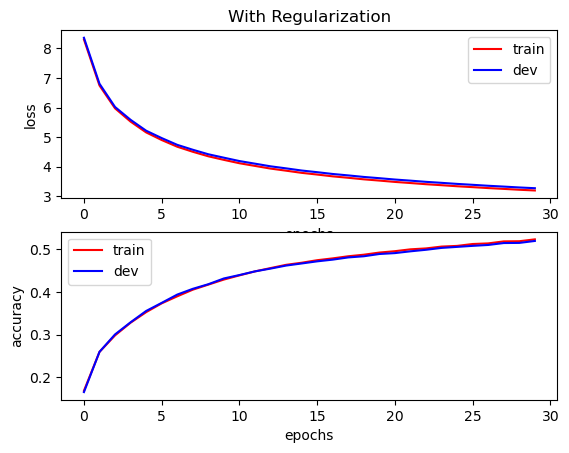

In [ ]:
def main(num_epochs=HPARAMS['num_epochs'], plot=True, train_baseline=True, train_regularized=True, test_set=False):
    
    np.random.seed(100)
    train_data, train_labels = read_data(
        '../data/images_train.csv', '../data/labels_train.csv')
    train_labels = one_hot_labels(train_labels)
    p = np.random.permutation(60000)
    train_data = train_data[p, :]
    train_labels = train_labels[p, :]

    dev_data = train_data[0:10000, :]
    dev_labels = train_labels[0:10000, :]
    train_data = train_data[10000:, :]
    train_labels = train_labels[10000:, :]

    mean = np.mean(train_data)
    std = np.std(train_data)
    train_data = (train_data - mean) / std
    dev_data = (dev_data - mean) / std

    test_data, test_labels = read_data(
        '../data/images_test.csv', '../data/labels_test.csv')
    test_labels = one_hot_labels(test_labels)
    test_data = (test_data - mean) / std

    all_data = {
        'train': train_data,
        'dev': dev_data,
        'test': test_data
    }

    all_labels = {
        'train': train_labels,
        'dev': dev_labels,
        'test': test_labels,
    }

    if train_baseline:
        run_train_test('baseline', all_data, all_labels,
                       backward_prop, num_epochs, plot, test_set=test_set)
    if train_regularized:
        print('Regularization param: ', HPARAMS['reg'])
        run_train_test('regularized', all_data, all_labels,
                       lambda a, b, c, d: backward_prop_regularized(
                           a, b, c, d, reg=HPARAMS['reg']),
                       num_epochs, plot, test_set=test_set)


if __name__ == '__main__':
    main()

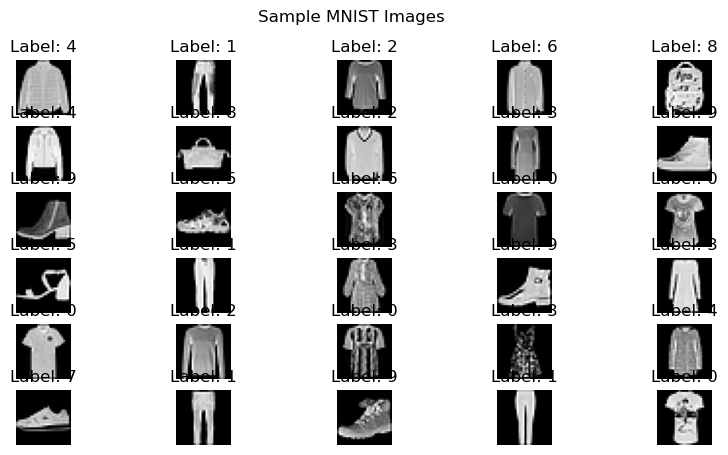

In [23]:
train_data, train_labels = read_data(
        '../data/images_train.csv', '../data/labels_train.csv')
train_labels = one_hot_labels(train_labels)
p = np.random.permutation(60000)
train_data = train_data[p, :]
train_labels = train_labels[p, :]

# Visualize 10 random images from the training dataset
visualize_sample_images(train_data[:30], train_labels[:30], num_samples=30)